## Analise comparativa entre sabesp e caixadagua

Primeiramente vamos realizar as importações dos pacotes necessários para a análise.
Após vamos carregar ambos os dados, da caixa d'agua e da sabesp

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import cm
import numpy as np
from math import nan

In [3]:
dfs = pd.read_csv('/Users/felipe.miziara/Documents/IPT/IOT/turbidez_sabesp3.csv', sep=';')
dfc = pd.read_csv('/Users/felipe.miziara/Documents/IPT/IOT/turbidez_caixa3.csv', sep=';')

dfs.rename(columns={'Valor': 'NTU'}, inplace=True)
dfs.head()


,Timestamp,Voltage,Sensor,NTU,Consumo Humano,Consumo Animal,Consumo Plantas
0,2024-07-14 14:27:18,0.518926,NaN,NaN,NaN,NaN,NaN
1,2024-07-14 14:27:23,0.000000,NaN,NaN,NaN,NaN,NaN
2,2024-07-14 14:27:28,0.000000,NaN,NaN,NaN,NaN,NaN
3,2024-07-14 14:27:33,0.000000,NaN,NaN,NaN,NaN,NaN
4,2024-07-14 14:27:38,0.000000,NaN,NaN,NaN,NaN,NaN


In [4]:
dfc.head()

,Timestamp,Voltage,Sensor,NTU,Consumo Humano,Consumo Animal,Consumo Plantas
0,2024-07-14 19:13:16,4.818071,Water Turbidity,3.638584,attention,clean,clean
1,2024-07-14 19:13:21,4.873016,Water Turbidity,2.539683,attention,clean,clean
2,2024-07-14 19:13:27,4.956044,Water Turbidity,0.879121,clean,clean,clean
3,2024-07-14 19:13:32,4.743590,Water Turbidity,5.128205,dirty,attention,clean
4,2024-07-14 19:13:37,4.747253,Water Turbidity,5.054945,dirty,attention,clean


In [5]:
#Corrigindo os tipos das colunas de tempo

dfs['Timestamp'] =  pd.to_datetime(dfs['Timestamp'])
dfc['Timestamp'] =  pd.to_datetime(dfc['Timestamp'])

#Limpando linhas sem data
if dfs['Timestamp'].isnull().any():
    dfs.dropna(subset=['Timestamp'], inplace=True) 
    
if dfc['Timestamp'].isnull().any():
    dfc.dropna(subset=['Timestamp'], inplace=True) 

#Limpando linhas sem valor
if dfs['NTU'].isnull().any():
    dfs.dropna(subset=['NTU'], inplace=True) 
    
if dfc['NTU'].isnull().any():
    dfc.dropna(subset=['NTU'], inplace=True) 

dfs['Grupos'] = dfs['Timestamp'].dt.floor('6min')
dfc['Grupos'] = dfc['Timestamp'].dt.floor('6min')
dfs.shape

(19754, 8)

In [6]:
dfc.shape

(25975, 8)

## Agrupando pelos intervalos de 6 min e removendo outliers


In [7]:
def remove_outliers_iqr(group):
    Q1 = group['NTU'].quantile(0.15)
    Q3 = group['NTU'].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[((group['NTU'] >= lower_bound) & (group['NTU'] <= upper_bound))]

dfs_agrupado = dfs.groupby('Grupos')
dfc_agrupado = dfc.groupby('Grupos')

# Aplique a função aos seus dados agrupados
dfsFiltrado = dfs_agrupado.apply(remove_outliers_iqr, include_groups=False)
dfcFiltrado = dfc_agrupado.apply(remove_outliers_iqr, include_groups=False)


# Visualize os resultados
dfsFiltrado.head()

Timestamp  Voltage           Sensor  NTU  \
Grupos                                                                        
2024-07-14 17:42:00 1297 2024-07-14 17:47:34      5.0  Water Turbidity  0.0   
                    1298 2024-07-14 17:47:39      5.0  Water Turbidity  0.0   
                    1299 2024-07-14 17:47:44      5.0  Water Turbidity  0.0   
                    1300 2024-07-14 17:47:49      5.0  Water Turbidity  0.0   
                    1301 2024-07-14 17:47:54      5.0  Water Turbidity  0.0   

                         Consumo Humano Consumo Animal Consumo Plantas  
Grupos                                                                  
2024-07-14 17:42:00 1297            NaN            NaN             NaN  
                    1298            NaN            NaN             NaN  
                    1299            NaN            NaN             NaN  
                    1300            NaN            NaN             NaN  
                    1301            NaN            NaN             NaN

In [8]:
dfsFinal = dfsFiltrado.groupby('Grupos')['NTU'].agg(['mean', 'std', 'min', 'max'])
dfcFinal = dfcFiltrado.groupby('Grupos')['NTU'].agg(['mean', 'std', 'min', 'max'])

dfsFinal.describe()

,mean,std,min,max
count,400.000000,393.000000,400.000000,400.000000
mean,10.448016,0.555504,9.759993,11.539232
std,86.298505,3.584510,86.263791,86.816691
min,0.000000,0.000000,0.000000,0.000000
25%,0.418794,0.000709,0.397705,0.431162
50%,1.672982,0.001247,1.622663,1.679490
75%,2.129714,0.002686,2.060209,2.155704
max,1000.000000,64.937795,1000.000000,1000.000000


In [9]:
dfcFinal.describe()

,mean,std,min,max
count,464.000000,463.000000,464.000000,464.000000
mean,73.607252,16.275231,56.323132,101.015252
std,290.264568,102.937569,331.659019,348.029972
min,-850.187843,0.000000,-3906.267578,0.000000
25%,1.033972,0.000785,0.987487,1.059108
50%,2.498504,0.060901,2.025312,2.832155
75%,63.002534,0.234175,62.310547,63.408997
max,2510.289975,1726.606489,2413.448975,2872.915039


## Analisando o período, comparando o sensor de entrega com o de saída

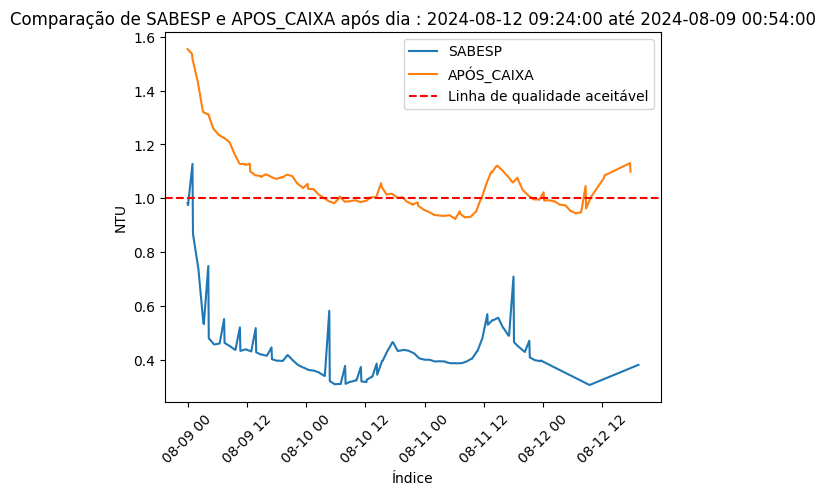

In [10]:
data_especifica = '2024-08-09'

dfsJanela = dfsFinal[dfsFinal.index.date >= pd.to_datetime(data_especifica).date()]
dfcJanela = dfcFinal[dfcFinal.index.date >= pd.to_datetime(data_especifica).date()]

min_data = dfsJanela.idxmin()
max_data = dfcJanela.idxmax()

#if not dfsJanela.index.equals(dfcJanela.index):
  # Reindexar dfcJanela se necessário
#  dfcJanela = dfcJanela.reindex(dfsJanela.index)

# Plotar os dados de dfsJanela
plt.plot(dfsJanela.index, dfsJanela['mean'], label='SABESP')

# Plotar os dados de dfcJanela
plt.plot(dfcJanela.index, dfcJanela['mean'], label='APÓS_CAIXA')

plt.axhline(y=1.0, color='r', linestyle='--', label='Linha de qualidade aceitável')


# Adicionar título, legenda e rótulos dos eixos
plt.title('Comparação de SABESP e APOS_CAIXA após dia : ' + str(min_data['min']) + ' até ' + str(max_data['max']))
plt.xlabel('Índice')
plt.ylabel('NTU')
#plt.xticks(dfsJanela.index)
plt.xticks(rotation=45)
plt.legend()

# Mostrar o gráfico
plt.show()

## Analisando o NTU em um dia específico, comparando a entreda e saída de água.

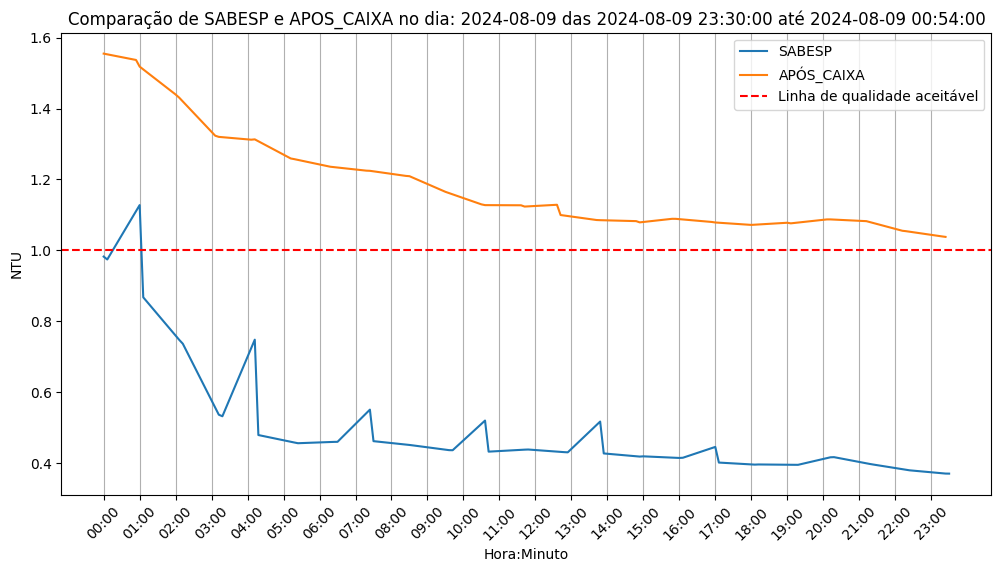

In [11]:
import matplotlib.dates as mdates

data_especifica = '2024-08-09'

dfsJanela = dfsFinal[dfsFinal.index.date == pd.to_datetime(data_especifica).date()]
dfcJanela = dfcFinal[dfcFinal.index.date == pd.to_datetime(data_especifica).date()]

min_data = dfsJanela.idxmin()
max_data = dfcJanela.idxmax()

# Converter os índices para datetime
dfsJanela.index = pd.to_datetime(dfsJanela.index)
dfcJanela.index = pd.to_datetime(dfcJanela.index)

plt.figure(figsize=(12, 6))

# Utilizar mdates.DateFormatter
date_form = mdates.DateFormatter("%H:%M")
plt.gca().xaxis.set_major_formatter(date_form)

# Plotar os dados de dfsJanela
plt.plot(dfsJanela.index, dfsJanela['mean'], label='SABESP')

# Plotar os dados de dfcJanela
plt.plot(dfcJanela.index, dfcJanela['mean'], label='APÓS_CAIXA')

plt.axhline(y=1.0, color='r', linestyle='--', label='Linha de qualidade aceitável')

# Adicionar título, legenda e rótulos dos eixos
plt.title('Comparação de SABESP e APOS_CAIXA no dia: '+ data_especifica + ' das ' + str(min_data['min']) + ' até ' + str(max_data['max']))
plt.xlabel('Hora:Minuto')
plt.ylabel('NTU')
plt.xticks(pd.date_range(dfsJanela.index.min(), dfsJanela.index.max(), freq='h')) 
plt.xticks(rotation=45)
plt.grid(axis='x')
plt.legend()

# Mostrar o gráfico
plt.show()

## Calculando a variação de NTU

/var/folders/db/b_fbt8vs3mq473t9zdmrmzgh0000gq/T/ipykernel_73542/1458931143.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')  # Mapa de cores com cores suficientes


KeyError: 'Var'

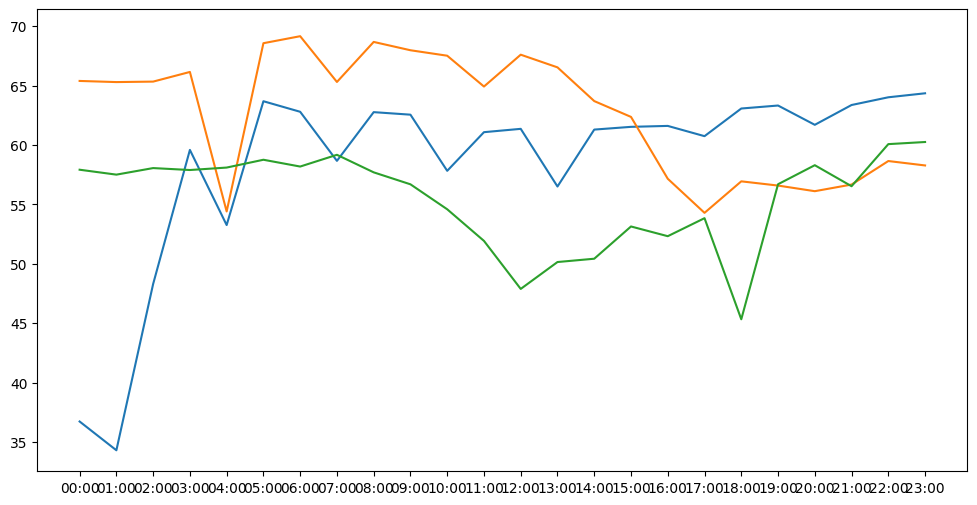

In [85]:
data_especifica = '2024-08-09'

dfsJanela = dfsFinal[dfsFinal.index.date >= pd.to_datetime(data_especifica).date()]
dfcJanela = dfcFinal[dfcFinal.index.date >= pd.to_datetime(data_especifica).date()]

min_data = dfsJanela.idxmin()
max_data = dfcJanela.idxmax()

dfsJanela.reset_index();
dfcJanela.reset_index();

def agrupar_por_dia_e_hora(grupo):
    return grupo.resample('h').mean() 

dfs_agrupado_por_dia_e_hora = dfsJanela.groupby(pd.Grouper(freq='D')).apply(agrupar_por_dia_e_hora)
dfc_agrupado_por_dia_e_hora = dfcJanela.groupby(pd.Grouper(freq='D')).apply(agrupar_por_dia_e_hora)

variacoes = pd.DataFrame(index=dfs_agrupado_por_dia_e_hora.index.get_level_values(1).strftime('%H:%M').unique())
# print (variacoes)
cont = 0
limiar_similaridade = 5
cmap = cm.get_cmap('tab20')  # Mapa de cores com cores suficientes

plt.figure(figsize=(12, 6))

nanArray = []

for valor in dfs_agrupado_por_dia_e_hora.index.get_level_values(0).unique():
    dfs_filtrado = dfs_agrupado_por_dia_e_hora.xs(valor, level=0)
    dfc_filtrado = dfc_agrupado_por_dia_e_hora.xs(valor, level=0)
    
    variacao_voltagem =  100 * (dfc_filtrado['mean']- dfs_filtrado['mean'])/dfc_filtrado['mean']
    
    variacao_voltagem.index = variacao_voltagem.index.strftime('%H:%M')
    
    df_variacao = pd.DataFrame({'Variacao': variacao_voltagem}, index=variacao_voltagem.index)
    
    plt.plot(df_variacao.index, df_variacao['Variacao'], label=valor)

    # valores = pd.Series(df_variacao['Variacao'].values)

    valores = df_variacao['Variacao'].values
        
    valores_completos = np.concatenate((valores, np.full(len(variacoes)-len(valores), np.nan)))
    
    # print (valores_completos)
    
    variacoes[valor] = valores_completos
    
    cont = cont + 1

# print(variacoes)


# diferencas = np.var(variacoes)

# print(diferencas)

variancia = pd.DataFrame(index=variacoes.index)


for horario in variacoes.index:
    variancia['Var'] = np.nanvar(variacoes.loc[horario].tolist())
    print(np.nanvar(variacoes.loc[horario].tolist()))

print(variancia)
# Iterar sobre os pares de datasets
# for i in range(len(variacoes)):
#     print(variacoes[i])
#     for j in range(i + 1, len(variacoes)):
#         var1 = variacoes[i]
#         var2 = variacoes[j]

#         # Calcular a diferença
#         if(i == 0 and j == 0):
#             diferenca = np.abs(var1 - var2)
#         else:
#             diferenca = np.abs(diferenca - var2)
        
# Encontrar os índices onde a diferença é menor que o limiar
# indices_similares_numericos = np.where(diferenca < limiar_similaridade)[0]
# indices_similares = var1.index[indices_similares_numericos]
        
# cor = cmap(i * len(variacoes) + j)
        
#         # Preencher a área de similaridade
#         plt.fill_between(
#             indices_similares,
#             var1.loc[indices_similares],
#             var2.loc[indices_similares],
#             color=cor,
#             alpha=0.3,  # Reduzir a opacidade para evitar sobreposição excessiva
#             label=f"Similaridade entre Dataset {i+1} e {j+1}" 
#         )

# x_ticks_labels = dfs_agrupado_por_dia_e_hora.index.levels[1].strftime('%H:%M').unique()

# plt.title('Variação de Turbidez: '+ data_especifica + ' das ' + str(min_data['min']) + ' até ' + str(max_data['max']))
# plt.xlabel('Hora:Minuto')
# plt.ylabel('Variação')

# plt.xticks(x_ticks_labels) 
# plt.xticks(rotation=45) 
# plt.grid(axis='x')

# plt.legend()
    


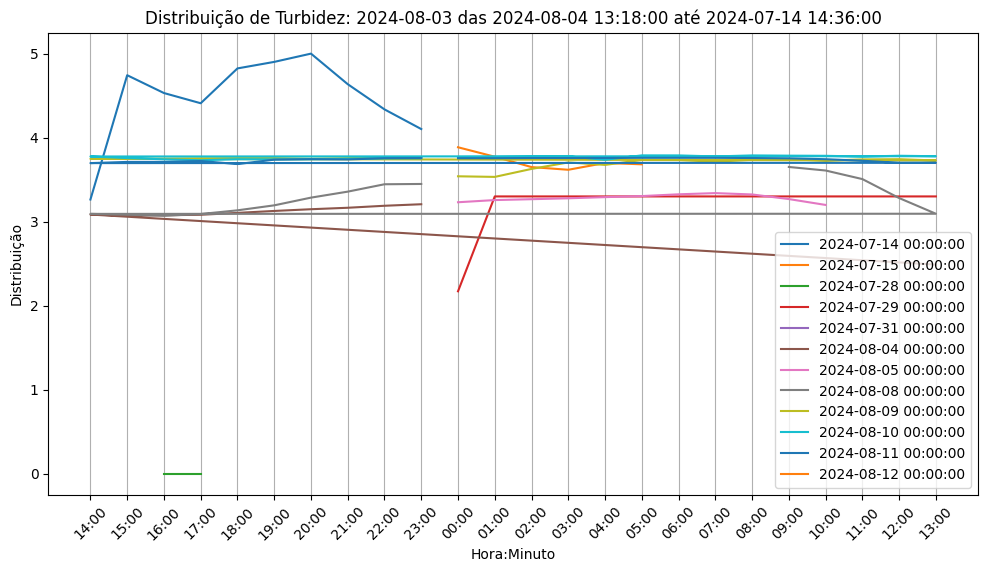

In [17]:
data_especifica = '2024-08-03'

#dfsJanela = dfsFinal[dfsFinal.index.date >= pd.to_datetime(data_especifica).date()]

dfsJanela = dfsFinal

min_data = dfsJanela.idxmin()
max_data = dfsJanela.idxmax()

dfsJanela.reset_index();

def agrupar_por_dia_e_hora(grupo):
    return grupo.resample('h').mean() 

dfs_agrupado_por_dia_e_hora = dfsJanela.groupby(pd.Grouper(freq='D')).apply(agrupar_por_dia_e_hora)

#Remover dia bugado
diaBugado = pd.to_datetime('2024-08-06')
dfs_agrupado_por_dia_e_hora = dfs_agrupado_por_dia_e_hora.drop(diaBugado)

plt.figure(figsize=(12, 6))

for valor in dfs_agrupado_por_dia_e_hora.index.get_level_values(0).unique():
    dfs_filtrado = dfs_agrupado_por_dia_e_hora.xs(valor, level=0)
        
    dfs_filtrado.index = dfs_filtrado.index.strftime('%H:%M')
    
    plt.plot(dfs_filtrado.index, dfs_filtrado['mean'], label=valor)


x_ticks_labels = dfs_agrupado_por_dia_e_hora.index.levels[1].strftime('%H:%M').unique()
plt.title('Distribuição de Turbidez: '+ data_especifica + ' das ' + str(min_data['min']) + ' até ' + str(max_data['max']))
plt.xlabel('Hora:Minuto')
plt.ylabel('Distribuição')

plt.xticks(x_ticks_labels) 
plt.xticks(rotation=45) 
plt.grid(axis='x')

plt.legend()
    
